In [11]:
import pandas as pd
import numpy as np
import matplotlib as plt

## Let's clean the data

In [2]:
df = pd.read_csv('data/all_transactions.csv')
df.head(5)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


Look at the types of the columns to see which ones may need to have their types changed.

In [3]:
df.dtypes

disclosure_year            int64
disclosure_date           object
transaction_date          object
owner                     object
ticker                    object
asset_description         object
type                      object
amount                    object
representative            object
district                  object
ptr_link                  object
cap_gains_over_200_usd      bool
dtype: object

disclosure_data and transaction_date can be represented in date time, but they are normal objects right now. 

In [4]:
df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], errors = 'coerce')
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors = 'coerce')
df.dtypes

disclosure_year                    int64
disclosure_date           datetime64[ns]
transaction_date          datetime64[ns]
owner                             object
ticker                            object
asset_description                 object
type                              object
amount                            object
representative                    object
district                          object
ptr_link                          object
cap_gains_over_200_usd              bool
dtype: object

Let's clean the 'Hon. ' out of every rep's name so it becomes easier to read.

In [5]:
df['representative'] = df['representative'].str.replace('Hon. ', '')

/var/folders/3k/d13l9xy576xd1j71sdj55ttc0000gn/T/ipykernel_18471/1258939511.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['representative'] = df['representative'].str.replace('Hon. ', '')


Let's create a 'state' column so we can do groupby state if we need to in the future.

In [6]:
df['state'] = df['district'].str[:2]

All done!

In [59]:
df.head(5)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,CA


In [8]:
# df.to_csv('data/cleaned_all_transactions.csv')

## EDA Time

### Univariate Analysis

We need to look at the distributions of relevant columns separately by using DataFrame operations and drawing appropriate plots. ```value_counts()``` will help us understand the values of a column.

Let's explore the ``disclosure_year`` columm first

In [26]:
# call .value_counts on 'disclosure_year'
df['disclosure_year'].value_counts()

2020    7379
2021    5520
2022    1303
Name: disclosure_year, dtype: int64

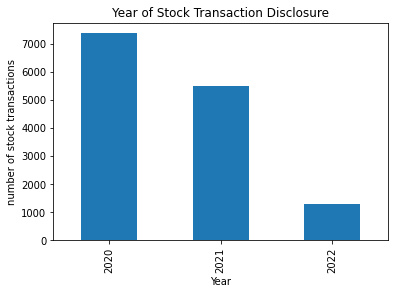

In [57]:
# first call .value_counts(), then .plot(), so graph is easier to read
df['disclosure_year'].value_counts().plot(kind = 'bar', \
    title = 'Year of Stock Transaction Disclosure', \
    xlabel = 'Year', ylabel = 'number of `stock transactions');

Clearly **2020** was the most popular year in this data set. This doesn't mean that the reps just traded more in 2020 than in 2021 or 2022, they probably just have not disclosed trades from those two years yet.

Now let's look at the ```ticker``` column. There are too many individiual tickers (abbreviations used to uniquely identify shares of a particular stock), so we will only look at the top 20.

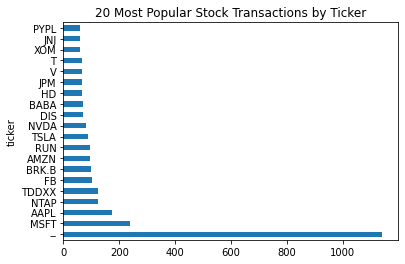

In [55]:
df['ticker'].value_counts()[:20].plot(kind = 'barh', \
    title = '20 Most Popular Stock Transactions by Ticker', \
    xlabel = 'ticker', ylabel = 'number of transactions');

Clearly, the most popular stock trades are in tech:
* Microsoft
* Apple
* NetApp
* FaceBook (Meta?)
* Amazon
* Tesla
* and so on...

But there is even a Fed Fund:
*  BLF FedFund (TDDXX)


**Surprised rich people are investing in fed funds?**

**Hey, maybe the old people in the House of Representatives *really do care***
**about their retirement funds!**


The biggest surprise, however, is the most popular ticker, '--', which isn't even a stock. What is '--'? Further digging will be done soon.

Now let's look at the ```amount``` column, to see how much of that 💰💸🤑 reps bring in.

In [43]:
df['amount'].value_counts()

$1,001 - $15,000            10008
$15,001 - $50,000            2237
$50,001 - $100,000            718
$100,001 - $250,000           545
$1,001 -                      242
$250,001 - $500,000           226
$500,001 - $1,000,000         142
$1,000,001 - $5,000,000        38
$1,000,000 +                   28
$5,000,001 - $25,000,000        9
$1,000 - $15,000                4
$15,000 - $50,000               3
$50,000,000 +                   1
$1,000,000 - $5,000,000         1
Name: amount, dtype: int64

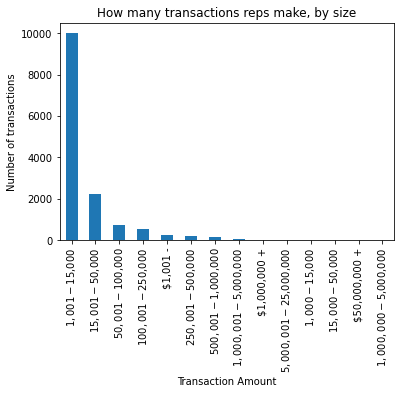

In [51]:
# first call .value_counts(), then .plot(), so graph is easier to read
df['amount'].value_counts().plot(kind = 'bar', \
    title = 'How many transactions reps make, by size', ylabel = 'Number of transactions', \
    xlabel = 'Transaction Amount');

### Bivariate Analysis

We need to look at the statistics of pairs of columns to identify possible associations. 

In [77]:
df.head(5)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,CA


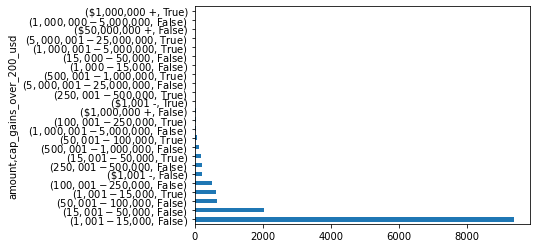

In [75]:
df[['amount', 'cap_gains_over_200_usd']].value_counts().plot(kind = 'barh');

Clearly, the three most popular categories of trade are:
* (1,001 - 15,000) and NO capital gains above $200
* (15,001 - 50,000) and NO capital gains above $200
* (50,001 - 100,000) and NO capital gains above $200

Reps need to realize they ain't so good at trading huh 🤣

In [80]:
df.pivot_table(index = 'disclosure_year', columns='amount', values = 'cap_gains_over_200_usd')

amount,"$1,000 - $15,000","$1,000,000 +","$1,000,000 - $5,000,000","$1,000,001 - $5,000,000","$1,001 -","$1,001 - $15,000","$100,001 - $250,000","$15,000 - $50,000","$15,001 - $50,000","$250,001 - $500,000","$5,000,001 - $25,000,000","$50,000,000 +","$50,001 - $100,000","$500,001 - $1,000,000"
disclosure_year,,,,,,,,,,,,,,
2020,NaN,0.000000,NaN,0.153846,0.073529,0.062241,0.132743,NaN,0.078571,0.104651,0.333333,0.0,0.095101,0.140000
2021,0.0,0.058824,0.0,0.000000,0.105263,0.080624,0.021583,0.0,0.114478,0.065421,0.000000,NaN,0.068404,0.014706
2022,NaN,NaN,NaN,0.000000,NaN,0.001103,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


Which state has the highest average number of trades that result in capital gains over $200?
Michigan! With a pretty mind blowing result of 77% 🤯

**Note:** The first that may come to mind is that Michigan may have had a high cap_gains_over_200_usd value for relatively small trades, in the $1,000 - $15,000 category, and low numbers in the rest. This would have induced Simpson's paradox. But we checked with another pivot table, and it is the case that Michigan has high cap_gains_over_200_usd values for *all* amount categories. 

In [88]:
(
    df.pivot_table(index = 'state', values = 'cap_gains_over_200_usd')
    .sort_values(by = 'cap_gains_over_200_usd', ascending=False)
)

,cap_gains_over_200_usd
state,
MI,0.772871
SC,0.379310
NY,0.280702
ID,0.222222
LA,0.222222
KY,0.115942
AR,0.111111
WI,0.105263
GA,0.103004
